In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

C:\Users\user\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file</h2>

In [2]:
X_train = pd.read_csv('final_features_tfidf_train.csv')
X_test = pd.read_csv('final_features_tfidf_test.csv')

In [3]:
y_train = pd.read_csv('final_features_tfidf_train_label.csv',header=None)
y_test = pd.read_csv('final_features_tfidf_test_label.csv',header=None)
y_train = y_train[1]
y_train = y_train.values.reshape((y_train.shape[0],1))
print(y_train.shape)
y_test = y_test[1]
y_test = y_test.values.reshape((y_test.shape[0],1))
print(y_test.shape)

(140000, 1)
(60000, 1)


In [4]:
X_train.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [5]:
X_train.head()

0_x  1_x  2_x  3_x  4_x  5_x  6_x  7_x  8_x  9_x  ...  freq_qid2  q1len  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          2     40   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          1     50   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...         12     37   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          2     60   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...          1     59   

   q2len  q1_n_words  q2_n_words  word_Common  word_Total  word_share  \
0     33           9           7          6.0        16.0    0.375000   
1     35           9           8          6.0        16.0    0.375000   
2     48           7           9          4.0        16.0    0.250000   
3     39          10           8          1.0        18.0    0.055556   
4    114          12          21          4.0        30.0    0.133333   

   freq_q1+q2  freq_q1-q2  
0           4           0  
1           3           1  
2          35          11  
3           4           0  
4           6           4  

[5 rows x 2026 columns]

<h2> 4.2 Converting strings to numerics </h2>

In [6]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_train.columns)
for i in cols:
    X_train[i] = X_train[i].apply(pd.to_numeric)
    #print(i)

In [7]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)
    #print(i)

<h2> 4.3 Generic method for plotting confusion matrix </h2>

In [8]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8946451543795837


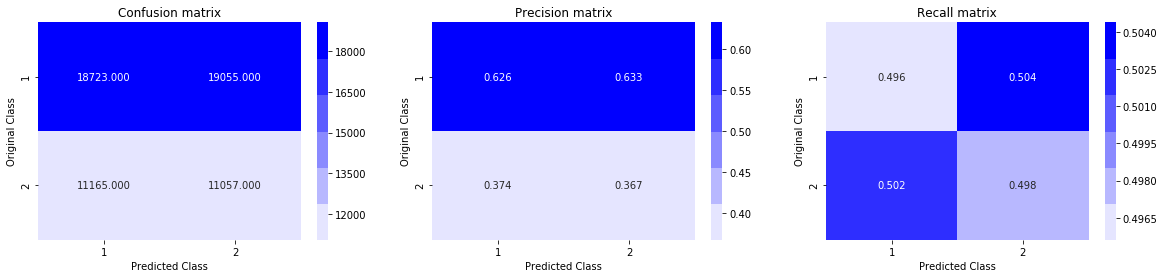

In [9]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = y_test.shape[0]
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.42107034776101715
For values of alpha =  0.0001 The log loss is: 0.4467932754269884
For values of alpha =  0.001 The log loss is: 0.45105223648176035
For values of alpha =  0.01 The log loss is: 0.4320378625142579
For values of alpha =  0.1 The log loss is: 0.4492084241860258
For values of alpha =  1 The log loss is: 0.4894598746560532
For values of alpha =  10 The log loss is: 0.5432669264172524


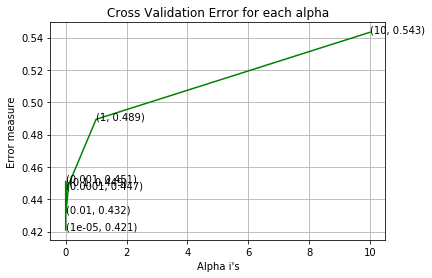

For values of best alpha =  1e-05 The train log loss is: 0.41918545363002374
For values of best alpha =  1e-05 The test log loss is: 0.42107034776101715
Total number of data points : 60000


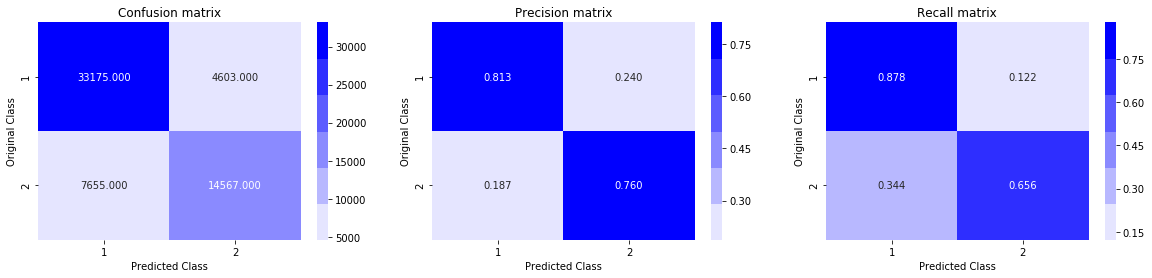

In [10]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4111543493357448
For values of alpha =  0.0001 The log loss is: 0.424165337237207
For values of alpha =  0.001 The log loss is: 0.4475273946489084
For values of alpha =  0.01 The log loss is: 0.459505556906909
For values of alpha =  0.1 The log loss is: 0.48317805572479033
For values of alpha =  1 The log loss is: 0.5807274815927826
For values of alpha =  10 The log loss is: 0.6428145505812121


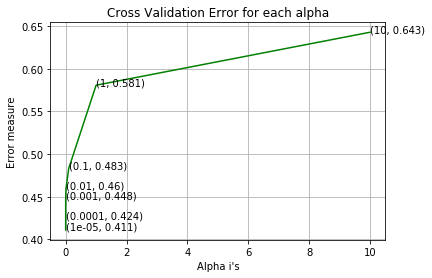

For values of best alpha =  1e-05 The train log loss is: 0.4072066344844586
For values of best alpha =  1e-05 The test log loss is: 0.4111543493357448
Total number of data points : 60000


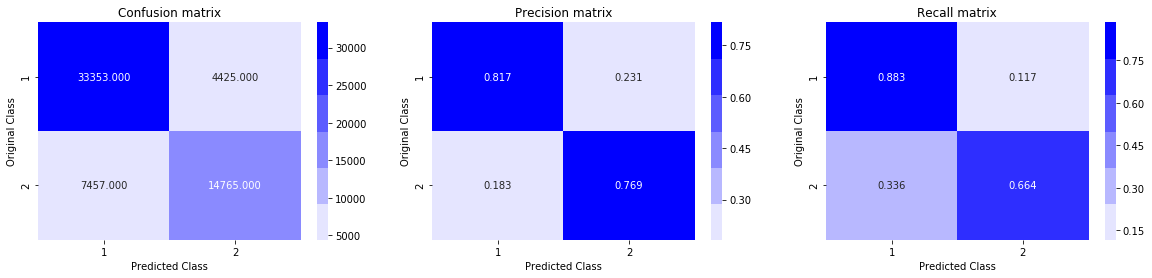

In [11]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

<h2> 4.6.1 Reading data from file</h2>

In [12]:
X_train = pd.read_csv('final_features_w2v_train.csv')
X_test = pd.read_csv('final_features_w2v_test.csv')

In [13]:
y_train = pd.read_csv('final_features_tfidf_train_label.csv',header=None)
y_test = pd.read_csv('final_features_tfidf_test_label.csv',header=None)
y_train = y_train[1]
y_train = y_train.values.reshape((y_train.shape[0],1))
print(y_train.shape)
y_test = y_test[1]
y_test = y_test.values.reshape((y_test.shape[0],1))
print(y_test.shape)

(140000, 1)
(60000, 1)


In [14]:
X_train.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)
X_test.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [15]:
X_train.head()

0_x        1_x         2_x         3_x        4_x        5_x  \
0   2.439142  18.114910  -12.255746  104.130825 -19.363592  -2.205739   
1 -15.773163  36.496838    8.192818   47.599665  37.109427  62.937893   
2 -12.001888  88.561495   54.594788    1.760126 -36.467282  33.917674   
3 -18.628788  74.915513  115.482397   50.463298 -12.816265 -43.315368   
4  -2.920037  64.090752    9.972080  105.365901  35.781809  31.707977   

          6_x         7_x        8_x        9_x  ...  freq_qid2  q1len  q2len  \
0  -13.635292   -3.182549  30.811532  -4.650403  ...          2     40     33   
1  -38.917103  -61.323661   5.005070 -25.191947  ...          1     50     35   
2  -59.055783  -20.182544  43.250478 -36.022031  ...         12     37     48   
3 -102.989147 -104.574963  46.028487 -52.984333  ...          2     60     39   
4  -89.826797  -13.955268  27.267864  18.659436  ...          1     59    114   

   q1_n_words  q2_n_words  word_Common  word_Total  word_share  freq_q1+q2  \
0           9           7          6.0        16.0    0.375000           4   
1           9           8          6.0        16.0    0.375000           3   
2           7           9          4.0        16.0    0.250000          35   
3          10           8          1.0        18.0    0.055556           4   
4          12          21          4.0        30.0    0.133333           6   

   freq_q1-q2  
0           0  
1           1  
2          11  
3           0  
4           4  

[5 rows x 794 columns]

<h2> 4.6.2 Converting strings to numerics </h2>

In [16]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_train.columns)
for i in cols:
    X_train[i] = X_train[i].apply(pd.to_numeric)
    #print(i)

In [17]:
# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(X_test.columns)
for i in cols:
    X_test[i] = X_test[i].apply(pd.to_numeric)
    #print(i)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'eta':[0.02,0.01,0.1]
        }


xgb = XGBClassifier(learning_rate=0.02, n_estimators=400, objective='binary:logistic',
                    silent=True, early_stopping_rounds=20)

In [19]:
folds = 3
param_comb = 10
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='neg_log_loss', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )
history = random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 220.1min finished


In [20]:
random_search.best_params_

{'subsample': 0.6,
 'min_child_weight': 1,
 'max_depth': 5,
 'gamma': 2,
 'eta': 0.02,
 'colsample_bytree': 1.0}

In [21]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5
params['booster'] = 'gbtree'
params['gama'] = 2
params['max_depth'] = 5
params['min_child_weight'] = 1
params['subsample'] = 0.6
params['colsample_bytree'] = 1

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.683686	valid-logloss:0.684189
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.610007	valid-logloss:0.610489
[20]	train-logloss:0.556155	valid-logloss:0.557228
[30]	train-logloss:0.515604	valid-logloss:0.516966
[40]	train-logloss:0.484679	valid-logloss:0.486367
[50]	train-logloss:0.460706	valid-logloss:0.462706
[60]	train-logloss:0.44181	valid-logloss:0.44415
[70]	train-logloss:0.426772	valid-logloss:0.429376
[80]	train-logloss:0.41461	valid-logloss:0.417434
[90]	train-logloss:0.404625	valid-logloss:0.407675
[100]	train-logloss:0.396265	valid-logloss:0.399621
[110]	train-logloss:0.389444	valid-logloss:0.393158
[120]	train-logloss:0.383771	valid-logloss:0.387708
[130]	train-logloss:0.378983	valid-logloss:0.383192
[140]	train-logloss:0.374681	valid-logloss:0.379133
[150]	train-logloss:0.370981	valid-logloss:0.375716
[160]	train-logloss:0.367785	va

Total number of data points : 60000


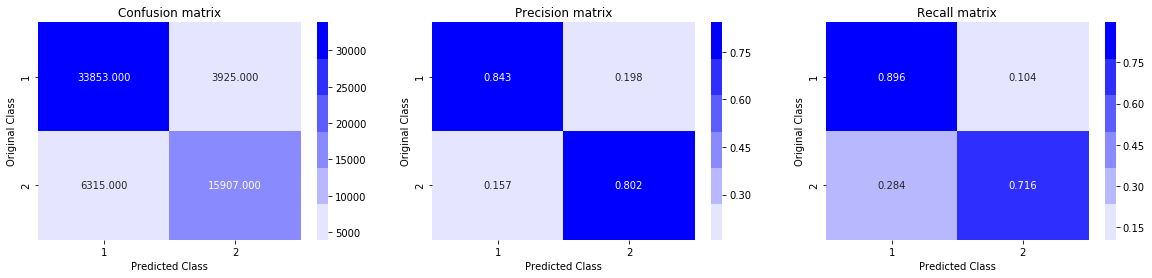

In [22]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [24]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model","train log loss", "test log loss", "train vs test precision", "train vs test recall"]
x.add_row(["TFIDF", "Linear Regression" , 0.4191, 0.429, "0.813 - 0.760","0.878 - 0.656"])
x.add_row(["TFIDF", "SVM" , 0.4072, 0.4111, "0.817 - 0.769","0.883 - 0.664"])
x.add_row(["TFIDFAvergeW2V", "XGBoost" , 0.3311, 0.3447, "0.843 - 0.802","0.896 - 0.716"])
x.border=True
print(x)

+----------------+-------------------+----------------+---------------+-------------------------+----------------------+
|   Vectorizer   |       Model       | train log loss | test log loss | train vs test precision | train vs test recall |
+----------------+-------------------+----------------+---------------+-------------------------+----------------------+
|     TFIDF      | Linear Regression |     0.4191     |     0.429     |      0.813 - 0.760      |    0.878 - 0.656     |
|     TFIDF      |        SVM        |     0.4072     |     0.4111    |      0.817 - 0.769      |    0.883 - 0.664     |
| TFIDFAvergeW2V |      XGBoost      |     0.3311     |     0.3447    |      0.843 - 0.802      |    0.896 - 0.716     |
+----------------+-------------------+----------------+---------------+-------------------------+----------------------+


`Clearly XGBoost Model is the best model as it has minimum train and test log loss and precission and recall are better than other two models`